In [1]:
import os
import zipfile 
import numpy as np
from dataset.data_management.data_manager import DataManager
from feature_engineering.datetime_parser import DatetimeParser
from feature_engineering.bool_parser import BoolParser
from feature_engineering.city_parser import CityParser
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_columns')
# pd.reset_option('display.max_rows')

In [3]:
import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
# logging.getLogger().setLevel(logging.INFO)
logging.getLogger().setLevel(logging.DEBUG)

In [4]:
dataset_dir = os.path.join(os.getcwd(), "dataset")
raw_csv_dir = os.path.join(dataset_dir,"raw","csv")
train_csv_path = os.path.join(raw_csv_dir, "train.csv")

data_warehouse_dir = os.path.join(dataset_dir, "data_warehouse")
data_warehouse_name = "train_data.parquet"
data_warehouse_path = os.path.join(data_warehouse_dir, data_warehouse_name)

#### View as string 

In [5]:
first_few_lines = []
with open(train_csv_path,"r") as train_csv_obj:
    for line_num, line in enumerate(train_csv_obj):
        if line_num >= 5:
            break
        first_few_lines.append(line)

In [6]:
# for line in first_few_lines:
#     print(line)

#### DataFrame

In [5]:
train_data = DataManager(data_warehouse_path, write_changes_mode=True)

2024-10-23 16:35:53,351 - INFO - All changes will be written to file when commited


In [6]:
# load from csv, done initially
train_data.load_data_file(train_csv_path) 

# load from last save point
# train_data.load_data_file()

/Users/stephenlee/Library/CloudStorage/GoogleDrive-stephjaelee@gmail.com/My Drive/Personal Projects/Projects/Epics/Kaggle-springleaf_marketing_response/kaggle_springleaf_marketing_response/dataset/data_management/data_manager.py:31: DtypeWarning: Columns (8,9,10,11,12,43,157,196,214,225,228,229,231,235,238) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(source_path, header=0)
2024-10-23 16:36:08,597 - DEBUG - /Users/stephenlee/Library/CloudStorage/GoogleDrive-stephjaelee@gmail.com/My Drive/Personal Projects/Projects/Epics/Kaggle-springleaf_marketing_response/kaggle_springleaf_marketing_response/dataset/raw/csv/train.csv as been loaded


In [7]:
# train_data.df.head()
train_data.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145231 entries, 0 to 145230
Columns: 1934 entries, ID to target
dtypes: float64(477), int64(1406), object(51)
memory usage: 2.1+ GB


It seems there are no variable names

In [8]:
total_rows, total_columns = train_data.df.shape
print(f"total_rows = {total_rows}\ntotal_columns = {total_columns}")

total_rows = 145231
total_columns = 1934


This is a lot of columns. 

In [9]:
train_data.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145231 entries, 0 to 145230
Columns: 1934 entries, ID to target
dtypes: float64(477), int64(1406), object(51)
memory usage: 2.1+ GB


Mostly floats, and int64. It would be interesting to see what the categorical columns are 

#### Delete null columns

In [12]:
print(f"Null columns : {train_data.df.isnull().all().sum()}")

Null columns : 3


In [13]:
null_columns = train_data.df.columns[train_data.df.isnull().all()]
print(f"Columns where all values are null: {null_columns}")

Columns where all values are null: Index(['VAR_0207', 'VAR_0213', 'VAR_0840'], dtype='object')


In [14]:
for column in null_columns:
    print(f" column {column} the unique values are {train_data.df[column].unique()}")

 column VAR_0207 the unique values are [nan]
 column VAR_0213 the unique values are [nan]
 column VAR_0840 the unique values are [nan]


In [15]:
train_data.df.drop(columns = null_columns, inplace=True)

In [16]:
def update_col_count(old_column:int, new_column:int) -> int:
    column_difference = old_column - new_column
    print(f"previous total_columns = {old_column}")
    print(f"impacted {column_difference} columns")
    return new_column

In [17]:
total_rows, new_total_columns = train_data.df.shape
total_columns = update_col_count(total_columns,new_total_columns)
print(f"total_rows = {total_rows}\ntotal_columns = {total_columns}")

previous total_columns = 1934
impacted 3 columns
total_rows = 145231
total_columns = 1931


In [18]:
train_data.commit_changes()

2024-10-22 22:04:38,883 - DEBUG - Data successfully written to /Users/stephenlee/Library/CloudStorage/GoogleDrive-stephjaelee@gmail.com/My Drive/Personal Projects/Projects/Epics/Kaggle-springleaf_marketing_response/kaggle_springleaf_marketing_response/dataset/data_warehouse/train_data.parquet


#### Handle duplicate rows

In [19]:
print(f"Duplicate rows : {train_data.df.duplicated().sum()}")

Duplicate rows : 0


#### Handle duplicate columns

In [20]:
train_data.pull_dataframe()

In [21]:
duplicate_columns = train_data.df.T.duplicated(keep = False)
print(f"Duplicate columns : {duplicate_columns[duplicate_columns == True].sum()}")

Duplicate columns : 63


In [22]:
duplicate_columns = train_data.df.T.duplicated(keep = 'first')
train_data.df = train_data.df.loc[:, ~duplicate_columns]

In [23]:
total_rows, new_total_columns = train_data.df.shape
total_columns = update_col_count(total_columns,new_total_columns)
print(f"total_rows = {total_rows}\ntotal_columns = {total_columns}")

previous total_columns = 1931
impacted 49 columns
total_rows = 145231
total_columns = 1882


In [24]:
train_data.commit_changes()

2024-10-22 22:06:37,357 - DEBUG - Data successfully written to /Users/stephenlee/Library/CloudStorage/GoogleDrive-stephjaelee@gmail.com/My Drive/Personal Projects/Projects/Epics/Kaggle-springleaf_marketing_response/kaggle_springleaf_marketing_response/dataset/data_warehouse/train_data.parquet


### Categorical Data

In [25]:
train_data.pull_dataframe()

In [26]:
df_unique_objects_summary = train_data.get_unique_values_summary(['object'], 10)
# df_unique_objects_summary

2024-10-22 22:06:38,333 - DEBUG - Filtering DataFrame for data types: ['object']
2024-10-22 22:06:38,359 - DEBUG - Filtered DataFrame columns: ['VAR_0001', 'VAR_0005', 'VAR_0008', 'VAR_0044', 'VAR_0073', 'VAR_0075', 'VAR_0156', 'VAR_0157', 'VAR_0158', 'VAR_0159', 'VAR_0166', 'VAR_0167', 'VAR_0168', 'VAR_0169', 'VAR_0176', 'VAR_0177', 'VAR_0178', 'VAR_0179', 'VAR_0200', 'VAR_0202', 'VAR_0204', 'VAR_0214', 'VAR_0216', 'VAR_0217', 'VAR_0222', 'VAR_0226', 'VAR_0230', 'VAR_0232', 'VAR_0236', 'VAR_0237', 'VAR_0274', 'VAR_0283', 'VAR_0305', 'VAR_0325', 'VAR_0342', 'VAR_0352', 'VAR_0353', 'VAR_0354', 'VAR_0404', 'VAR_0466', 'VAR_0467', 'VAR_0493', 'VAR_1934']
2024-10-22 22:06:38,620 - DEBUG - Summary DataFrame created


#### Build Datetime Features

In [27]:
train_data.pull_dataframe()

In [28]:
datetime_parser = DatetimeParser(train_data.df)

In [29]:
object_columns = list(train_data.get_unique_values_summary(['object'], 10).index)

2024-10-22 22:06:39,781 - DEBUG - Filtering DataFrame for data types: ['object']
2024-10-22 22:06:39,801 - DEBUG - Filtered DataFrame columns: ['VAR_0001', 'VAR_0005', 'VAR_0008', 'VAR_0044', 'VAR_0073', 'VAR_0075', 'VAR_0156', 'VAR_0157', 'VAR_0158', 'VAR_0159', 'VAR_0166', 'VAR_0167', 'VAR_0168', 'VAR_0169', 'VAR_0176', 'VAR_0177', 'VAR_0178', 'VAR_0179', 'VAR_0200', 'VAR_0202', 'VAR_0204', 'VAR_0214', 'VAR_0216', 'VAR_0217', 'VAR_0222', 'VAR_0226', 'VAR_0230', 'VAR_0232', 'VAR_0236', 'VAR_0237', 'VAR_0274', 'VAR_0283', 'VAR_0305', 'VAR_0325', 'VAR_0342', 'VAR_0352', 'VAR_0353', 'VAR_0354', 'VAR_0404', 'VAR_0466', 'VAR_0467', 'VAR_0493', 'VAR_1934']
2024-10-22 22:06:40,056 - DEBUG - Summary DataFrame created


In [30]:
datetime_parser.parse_columns(col_names=object_columns
                              , drop_original=True)

2024-10-22 22:06:40,068 - DEBUG -  column count at start of parse_columns = 1882
2024-10-22 22:06:40,078 - DEBUG - Column VAR_0001 successful conversion ratio: 0.0
2024-10-22 22:06:40,086 - DEBUG - Column VAR_0005 successful conversion ratio: 0.0
2024-10-22 22:06:40,091 - DEBUG - Column VAR_0008 successful conversion ratio: 0.0
2024-10-22 22:06:40,096 - DEBUG - Column VAR_0044 successful conversion ratio: 0.0
2024-10-22 22:06:40,107 - DEBUG - Column VAR_0073 successful conversion ratio: 0.3036817208447232
2024-10-22 22:06:40,108 - DEBUG - Column VAR_0073 successfully parsed to datetime
2024-10-22 22:06:43,808 - DEBUG - Column 'VAR_0073' contains only null or zero values
2024-10-22 22:06:43,810 - DEBUG - Dropping original column: VAR_0073, since drop_original= True
2024-10-22 22:06:44,257 - DEBUG - Column VAR_0075 successful conversion ratio: 0.9996144073923612
2024-10-22 22:06:44,258 - DEBUG - Column VAR_0075 successfully parsed to datetime
2024-10-22 22:06:47,194 - DEBUG - Column 'VAR

In [31]:
train_data.df = datetime_parser.df
del datetime_parser.df

In [32]:
train_data.commit_changes()

2024-10-22 22:07:44,357 - DEBUG - Data successfully written to /Users/stephenlee/Library/CloudStorage/GoogleDrive-stephjaelee@gmail.com/My Drive/Personal Projects/Projects/Epics/Kaggle-springleaf_marketing_response/kaggle_springleaf_marketing_response/dataset/data_warehouse/train_data.parquet


#### Boolean

In [33]:
train_data.pull_dataframe()

In [34]:
df_unique_objects_summary = train_data.get_unique_values_summary(['object'], 10)
# df_unique_objects_summary

2024-10-22 22:07:45,578 - DEBUG - Filtering DataFrame for data types: ['object']
2024-10-22 22:07:45,592 - DEBUG - Filtered DataFrame columns: ['VAR_0001', 'VAR_0005', 'VAR_0008', 'VAR_0044', 'VAR_0200', 'VAR_0202', 'VAR_0214', 'VAR_0216', 'VAR_0222', 'VAR_0226', 'VAR_0230', 'VAR_0232', 'VAR_0236', 'VAR_0237', 'VAR_0274', 'VAR_0283', 'VAR_0305', 'VAR_0325', 'VAR_0342', 'VAR_0352', 'VAR_0353', 'VAR_0354', 'VAR_0404', 'VAR_0466', 'VAR_0467', 'VAR_0493', 'VAR_1934']
2024-10-22 22:07:45,772 - DEBUG - Summary DataFrame created


In [35]:
bool_parser = BoolParser(train_data.df)

In [36]:
object_columns = list(train_data.get_unique_values_summary(['object'], 10).index)

2024-10-22 22:07:46,740 - DEBUG - Filtering DataFrame for data types: ['object']
2024-10-22 22:07:46,757 - DEBUG - Filtered DataFrame columns: ['VAR_0001', 'VAR_0005', 'VAR_0008', 'VAR_0044', 'VAR_0200', 'VAR_0202', 'VAR_0214', 'VAR_0216', 'VAR_0222', 'VAR_0226', 'VAR_0230', 'VAR_0232', 'VAR_0236', 'VAR_0237', 'VAR_0274', 'VAR_0283', 'VAR_0305', 'VAR_0325', 'VAR_0342', 'VAR_0352', 'VAR_0353', 'VAR_0354', 'VAR_0404', 'VAR_0466', 'VAR_0467', 'VAR_0493', 'VAR_1934']
2024-10-22 22:07:46,940 - DEBUG - Summary DataFrame created


In [37]:
bool_parser.parse_columns(object_columns)

2024-10-22 22:07:47,119 - DEBUG - Boolean columns: ['VAR_0008', 'VAR_0226', 'VAR_0230', 'VAR_0232', 'VAR_0236']
2024-10-22 22:07:47,134 - DEBUG - Column VAR_0008 has been converted to Int64.
2024-10-22 22:07:47,137 - DEBUG - Column VAR_0008's nan has been one-hot encoded.
2024-10-22 22:07:47,151 - DEBUG - Column VAR_0226 has been converted to Int64.
2024-10-22 22:07:47,153 - DEBUG - Column VAR_0226's nan has been one-hot encoded.
2024-10-22 22:07:47,168 - DEBUG - Column VAR_0230 has been converted to Int64.
2024-10-22 22:07:47,170 - DEBUG - Column VAR_0230's nan has been one-hot encoded.
2024-10-22 22:07:47,185 - DEBUG - Column VAR_0232 has been converted to Int64.
2024-10-22 22:07:47,187 - DEBUG - Column VAR_0232's nan has been one-hot encoded.
2024-10-22 22:07:47,201 - DEBUG - Column VAR_0236 has been converted to Int64.
2024-10-22 22:07:47,203 - DEBUG - Column VAR_0236's nan has been one-hot encoded.


In [38]:
train_data.df = bool_parser.df

In [39]:
train_data.commit_changes()

2024-10-22 22:07:51,610 - DEBUG - Data successfully written to /Users/stephenlee/Library/CloudStorage/GoogleDrive-stephjaelee@gmail.com/My Drive/Personal Projects/Projects/Epics/Kaggle-springleaf_marketing_response/kaggle_springleaf_marketing_response/dataset/data_warehouse/train_data.parquet


#### One-hot encoding

In [40]:
train_data.pull_dataframe()

In [41]:
df_unique_objects_summary = train_data.get_unique_values_summary(['object'], 10)
# df_unique_objects_summary

2024-10-22 22:07:53,115 - DEBUG - Filtering DataFrame for data types: ['object']
2024-10-22 22:07:53,130 - DEBUG - Filtered DataFrame columns: ['VAR_0001', 'VAR_0005', 'VAR_0044', 'VAR_0200', 'VAR_0202', 'VAR_0214', 'VAR_0216', 'VAR_0222', 'VAR_0237', 'VAR_0274', 'VAR_0283', 'VAR_0305', 'VAR_0325', 'VAR_0342', 'VAR_0352', 'VAR_0353', 'VAR_0354', 'VAR_0404', 'VAR_0466', 'VAR_0467', 'VAR_0493', 'VAR_1934']
2024-10-22 22:07:53,281 - DEBUG - Summary DataFrame created


2024-10-22 22:07:53,314 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-10-22 22:07:53,316 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-10-22 22:07:53,321 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-10-22 22:07:53,321 - DEBUG - findfont: score(FontEntry(fname='/Users/stephenlee/Library/CloudStorage/GoogleDrive-stephjaelee@gmail.com/My Drive/Personal Projects/Projects/Epics/Kaggle-springleaf_marketing_response/kaggle_springleaf_marketing_response/kaggle_springleaf_env/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-10-22 22:07:53,322 - DEBUG - findfont: score(FontEntry(fname='/Users/stephenlee/Library/CloudStorage/GoogleDrive-stephjaelee@gmail.com/My Drive/Personal Projects/Projects/Epic

<Axes: xlabel='VAR_0274'>

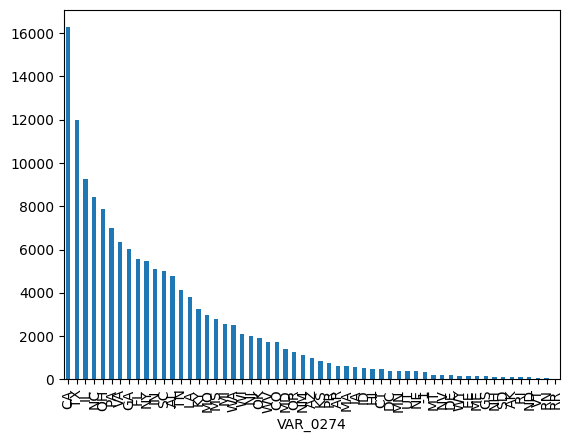

In [42]:
VAR_0274 = train_data.df['VAR_0274'].value_counts()
VAR_0274.plot(kind='bar')
# plt.show()

VAR_0237 VAR_0214 both seem like states

In [43]:
states_match = train_data.df['VAR_0237'].str.strip().str.lower() == train_data.df['VAR_0274'].str.strip().str.lower()
total = len(states_match)
percent_match = states_match.sum() / total * 100

In [44]:
print(f"Percent of states that match: {percent_match:.2f}%")

Percent of states that match: 67.86%


It doesn't seem like these columns are equal, so initially keeping both

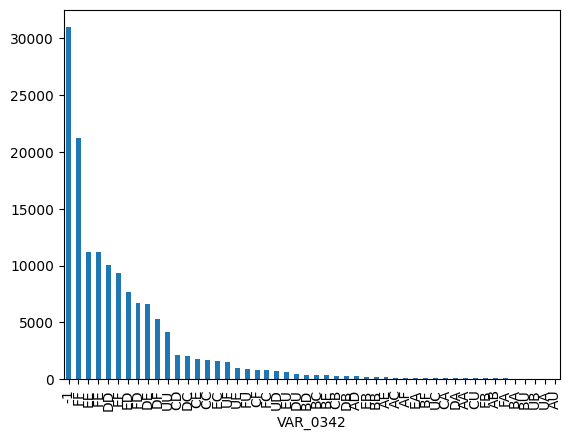

In [45]:
var_0342 = train_data.df['VAR_0342'].value_counts()
var_0342.plot(kind='bar')
plt.show()

For simiplicity, we will one hot encode everything under 60 unique values

In [46]:
df_one_hot_encoding_meta = df_unique_objects_summary[df_unique_objects_summary['total_unique_count'] <= 60]
# df_one_hot_encoding_meta

In [47]:
one_hot_encoding_cols = df_one_hot_encoding_meta.index.to_list()
df_encoded_cols = pd.get_dummies(train_data.df[one_hot_encoding_cols], dummy_na=True)
df_encoded_cols = df_encoded_cols.astype(int)

# remove state columns from drop list as they will be needed for future use
state_columns = ['VAR_0237','VAR_0274']
one_hot_encoding_cols = [col for col in one_hot_encoding_cols if col not in state_columns]

train_data.df.drop(columns = one_hot_encoding_cols, inplace=True)
train_data.df = pd.concat([train_data.df, df_encoded_cols], axis=1)

In [48]:
train_data.commit_changes()

2024-10-22 22:08:02,007 - DEBUG - Data successfully written to /Users/stephenlee/Library/CloudStorage/GoogleDrive-stephjaelee@gmail.com/My Drive/Personal Projects/Projects/Epics/Kaggle-springleaf_marketing_response/kaggle_springleaf_marketing_response/dataset/data_warehouse/train_data.parquet


#### City Location Handling

In [10]:
train_data.pull_dataframe()

In [11]:
df_unique_objects_summary = train_data.get_unique_values_summary(['object'], 10)

2024-10-23 16:36:39,823 - DEBUG - Filtering DataFrame for data types: ['object']
2024-10-23 16:36:39,828 - DEBUG - Filtered DataFrame columns: ['VAR_0200', 'VAR_0237', 'VAR_0274', 'VAR_0404', 'VAR_0493']
2024-10-23 16:36:39,866 - DEBUG - Summary DataFrame created


In [12]:
df_unique_objects_summary

,unique_values_sample,total_unique_count,percent_null
VAR_0200,['FT LAUDERDALE' 'SANTEE' 'REEDSVILLE' 'LIBERT...,12385,0.04
VAR_0237,['FL' 'CA' 'WV' 'TX' 'IL' 'OR' 'GA' 'PA' 'TN' ...,45,0.04
VAR_0274,['FL' 'MI' 'WV' 'TX' 'IL' 'ME' 'CA' 'SC' 'PA' ...,57,0.63
VAR_0404,['CHIEF EXECUTIVE OFFICER' '-1' 'CONTA' 'CONTA...,1823,0.63
VAR_0493,['COMMUNITY ASSOCIATION MANAGER' '-1' 'LICENSE...,608,0.63


In [13]:
city_column = ['VAR_0200']

In [14]:
state_columns = ['VAR_0237','VAR_0274']

In [15]:
# train_data.df[city_column].head(10)

In [16]:
df_locations = train_data.df.groupby(city_column+state_columns).size().reset_index(name='frequency')

In [17]:
# df_locations.loc[20:40, :]

In [18]:
VAR_0237_frequency = train_data.df.groupby(['VAR_0200', 'VAR_0237']).size().reset_index(name='count_0237')
VAR_0274_frequency = train_data.df.groupby(['VAR_0200', 'VAR_0274']).size().reset_index(name='count_0274')

In [19]:
print(f'average consistency for city-state pairs in VAR_0237: {VAR_0237_frequency["count_0237"].mean():.2f}')
print(f'average consistency for city-state pairs in VAR_0274: {VAR_0274_frequency["count_0274"].mean():.2f}')

average consistency for city-state pairs in VAR_0237: 8.96
average consistency for city-state pairs in VAR_0274: 3.77


VAR_0237 shows more consistent matches between cities and states, averaging 9 matches compared to 4 for VAR_0274. This suggests that VAR_0237 is likely a more reliable indicator of the correct state for each city

In [20]:
city_list = [str(city) for city in train_data.df['VAR_0200'].unique()]
city_list.sort()
# print(', '.join(city_list))

The city list is messy, they need to be collapsed, it seems like this is user input

##### Clean city names

Issues with column VAR_0200
- zip codes
  - If I see numbers, assume it's a zip code, get lat/lon, then get city name
- number mixed with city names
  - remove the numbers and just assume it's a city
- some cities are spelled incorrectly
  - use fuzzy string matching plus state matching

In [21]:
city_fact_table = "city_fact.parquet"
city_fact_path = os.path.join(data_warehouse_dir, city_fact_table)

In [22]:
state_col = 'VAR_0237'
city_col = 'VAR_0200'

In [23]:
city_parser = CityParser(train_data.df, city_fact_path, city_col, state_col)

In [24]:
city_parser.parse_column()

2024-10-23 16:36:44,240 - DEBUG - city column cleaned


In [25]:
no_var_col = [col for col in city_parser.df.columns if not col.startswith('VAR')]
location_columns = no_var_col + [city_parser.state_col, city_parser.city_col]
location_columns.sort()
print(location_columns)
print('\n')
city_parser.df.loc[13080:13085, location_columns]

['ID', 'VAR_0200', 'VAR_0237', 'lat', 'lon', 'original_city_col', 'target', 'zip_code']




,ID,VAR_0200,VAR_0237,lat,lon,original_city_col,target,zip_code
13080,25929,HAVELOCK,NC,<NA>,<NA>,HAVELOCK,0,NaN
13081,25930,PORTERVILLE,CA,<NA>,<NA>,PORTERVILLE,1,NaN
13082,25931,SNELLVILLE,GA,33.7972,84.0273,30039,1,30039
13083,25932,CORPUS CHRISTI,TX,<NA>,<NA>,CORPUS CHRISTI,1,NaN
13084,25933,PLEASANT GROVE,AL,<NA>,<NA>,PLEASANT GROVE,0,NaN
13085,25934,WEST COLUMBIA,SC,<NA>,<NA>,WEST COLUMBIA,0,NaN


In [26]:
city_parser.df.loc[city_parser.df['VAR_0200'] == 'SNELLVILLE', location_columns].head()

,ID,VAR_0200,VAR_0237,lat,lon,original_city_col,target,zip_code
3362,6593,SNELLVILLE,GA,33.7972,84.0273,SNELLVILLE,1,30039
6696,13148,SNELLVILLE,GA,33.7972,84.0273,SNELLVILLE,0,30039
8926,17682,SNELLVILLE,GA,33.7972,84.0273,SNELLVILLE,0,30039
12855,25502,SNELLVILLE,GA,33.7972,84.0273,SNELLVILLE,1,30039
13082,25931,SNELLVILLE,GA,33.7972,84.0273,30039,1,30039


In [ ]:
city_parser.fuzzy_match_and_group_cities()

2024-10-23 16:36:52,854 - DEBUG - Finding similar cities for KING COVE in AK
2024-10-23 16:36:52,858 - DEBUG - Finding similar cities for CAMP HILL in AL
2024-10-23 16:36:52,860 - DEBUG - Finding similar cities for HARTSELLE in AL
2024-10-23 16:36:52,862 - DEBUG - Finding similar cities for HUEYTOWN in AL
2024-10-23 16:36:52,866 - DEBUG - Finding similar cities for FLORENCE in AL
2024-10-23 16:36:52,868 - DEBUG - Finding similar cities for EASTABOGA in AL
2024-10-23 16:36:52,869 - DEBUG - Finding similar cities for WEBB in AL
2024-10-23 16:36:52,871 - DEBUG - Finding similar cities for MUSCLE SHOALS in AL
2024-10-23 16:36:52,872 - DEBUG - Finding similar cities for MONTGOMERY in AL
2024-10-23 16:36:52,874 - DEBUG - Finding similar cities for HUNTSVILLE in AL
2024-10-23 16:36:52,875 - DEBUG - Finding similar cities for FORT PAYNE in AL
2024-10-23 16:36:52,877 - DEBUG - Finding similar cities for SARALAND in AL
2024-10-23 16:36:52,878 - DEBUG - Finding similar cities for SATSUMA in AL
20

In [ ]:
city_parser.df.loc[city_parser.df[city_parser.city_col].isnull()][:5]